In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

import shap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df = pd.read_csv('xai.csv', index_col=False)
df.columns = [i.zfill(2) for i in df.columns]
df.drop(axis=1, labels = 'Unnamed: 0', inplace=True)
df.head(5)

00  01  02  03  04  05  06  07  08  09  ...  f7  f8  f9  fa  fb  fc  fd  \
0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

   fe  ff  Class  
0   0   0      1  
1   0   0      1  
2   0   0      1  
3   0   0      1  
4   0   0      1  

[5 rows x 257 columns]

In [3]:
X = df
y = df.pop('Class')

X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=42)

In [21]:
X_test.shape

(3642, 256)

In [4]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           1       0.85      0.88      0.87       114
           2       0.71      0.67      0.69       208
           3       0.54      0.51      0.53       219
           4       0.79      0.25      0.38       105
           5       0.86      0.86      0.86       785
           6       0.57      0.44      0.50       197
           7       0.90      0.68      0.78        66
           8       0.63      0.85      0.72       767
           9       0.75      0.11      0.19        55
          10       0.67      0.38      0.49       180
          11       0.80      0.79      0.79       121
          12       0.78      0.87      0.82       602
          13       0.84      0.70      0.76       131
          14       0.69      0.40      0.51        92

    accuracy                           0.73      3642
   macro avg       0.74      0.60      0.63      3642
weighted avg       0.74      0.73      0.72      3642



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [6]:
explainer = shap.Explainer(lr, X_train, feature_names=X_train.columns)
shap_values = explainer.shap_values(X_test.values)

In [ ]:
print(len(shap_values))
print(shap_values)

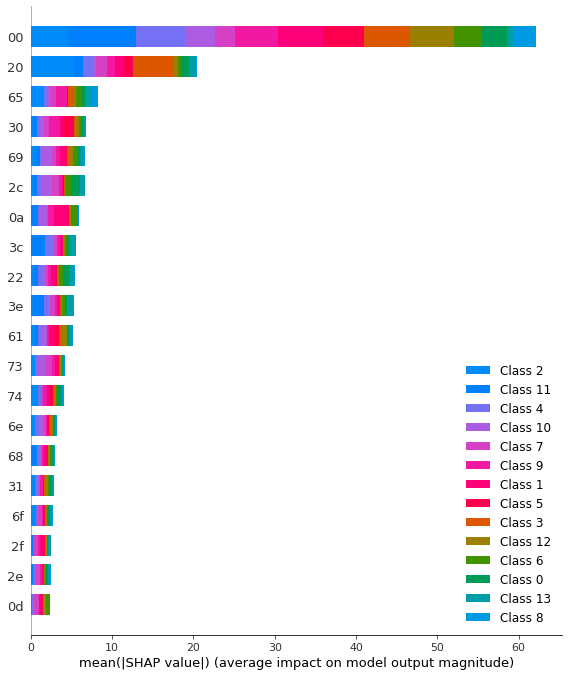

In [8]:
shap.initjs()
shap.summary_plot(shap_values, X_test,show=False)
plt.savefig('lr_summary.png')

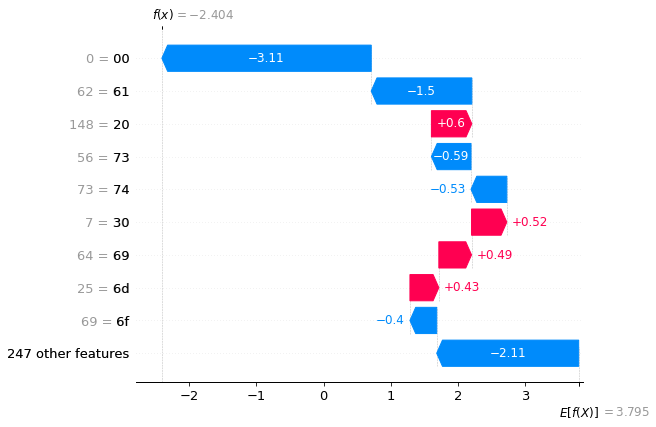

In [31]:
instance_index = 0 #index from the number of rows in the test data: 0-3642

# Obtain the class that the model predicted for the selected instance
predicted_class = lr.predict(X_test.iloc[instance_index:instance_index+1])[0]


expl = shap.Explanation(values=shap_values[predicted_class][instance_index],
                        base_values=explainer.expected_value[predicted_class],
                        data=X_test.iloc[instance_index],
                        feature_names=X_test.columns)

#shap values list range from 0-13
#expl = shap.Explanation(values=shap_values[0][instance_index],
                        #base_values=explainer.expected_value[0], #expected value for the first class: class 0
                        #data=X_test.iloc[instance_index],
                        #feature_names=X_test.columns)

# Generate the waterfall plot for the chosen instance using the Explanation object
shap.waterfall_plot(expl, show=False)

plt.savefig('lr_waterfall_instance_{}_class_{}.png'.format(instance_index, predicted_class))


In [37]:
instance_index = 0

for class_index in range(len(shap_values)):
    
    # Get the SHAP values for the instance and class
    shap_values_instance_class = shap_values[class_index][instance_index]
    
    expl = shap.Explanation(values=shap_values_instance_class,
                            base_values=explainer.expected_value[class_index],
                            data=X_test.iloc[instance_index],
                            feature_names=X_test.columns)
    
    shap.waterfall_plot(expl, show=False)
    
    plt.gcf().set_size_inches(12, 8)
    plt.tight_layout()
    
    plt.savefig('lr_waterfall_instance_{}_class_{}.png'.format(instance_index, class_index), dpi=1500)
    plt.close()

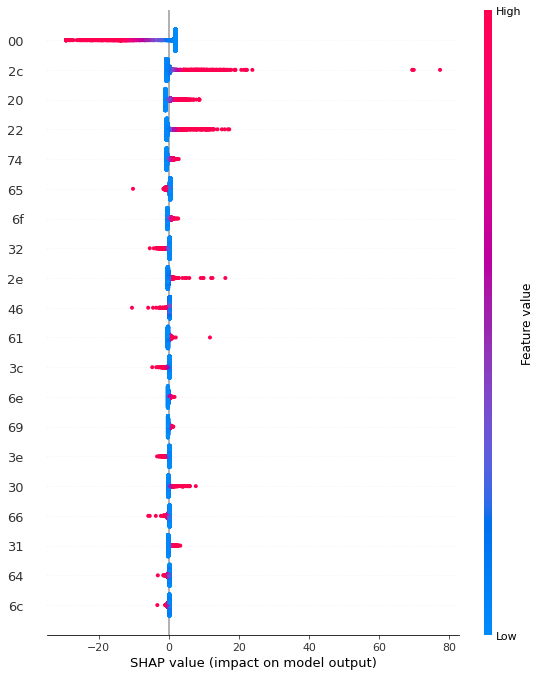

In [16]:
shap.initjs()
shap.summary_plot(shap_values[0], X_test,show=False)
plt.savefig('lr_instance_0.png')

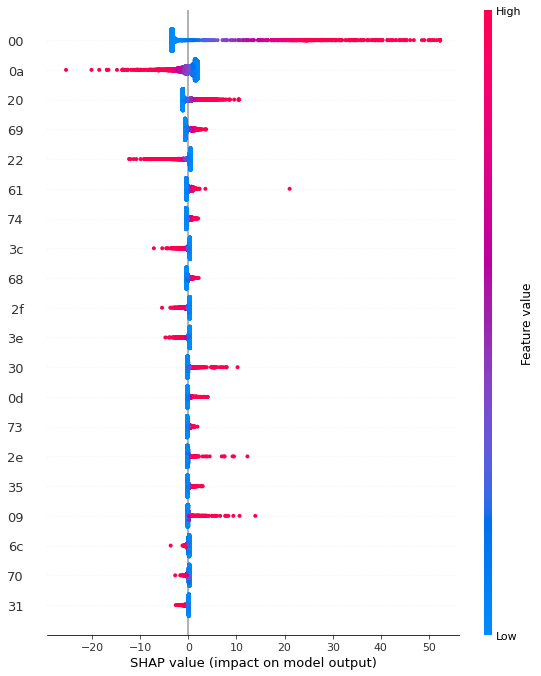

In [17]:
shap.initjs()
shap.summary_plot(shap_values[1], X_test,show=False)
plt.savefig('lr_instance_1.png')

In [27]:
#explanation = shap.Explanation(values=shap_values)
#get the plot for each class

for class_label in range(14):

    shap_values_class = shap_values[class_label]

    explanation = shap.Explanation(values=shap_values_class)

    shap.plots.beeswarm(explanation, max_display=10,show=False)
    
    plt.savefig('lr_' + str(class_label) + '.png', bbox_inches='tight')

    plt.close()

The below code helps to get the first 10 features with negatiev impact


In [14]:
class_index = 0  # Replace with the class index you want to analyze
shap_values_class = shap_values[class_index]

# Sort the absolute SHAP values in descending order
abs_shap_values = abs(shap_values_class)
sorted_indices = abs_shap_values.argsort()[::-1]

# Get the top 10 features with the most significant negative impact
top_10_negative_features = sorted_indices[:10]

# Print the feature indices or names
print("Top 10 features with negative impact for class", class_index)
print(top_10_negative_features)


Top 10 features with negative impact for class 0
[[113  10 106 ... 101 116   0]
 [ 84  96  74 ... 116  32   0]
 [ 77 121  89 ... 116  32   0]
 ...
 [222  74  89 ...  44  32   0]
 [ 66  37 113 ...  69   0  32]
 [ 10  37 113 ...  50   0  44]]


In [15]:
#store the aggregate scores for each feature
feature_scores = np.zeros(X_test.shape[1])

#Iterate through each class and accumulate the absolute SHAP values for each feature
for class_index in range(14):
    shap_values_class = shap_values[class_index].mean(0)  # Aggregate SHAP values across samples
    feature_scores += np.abs(shap_values_class)

# Sort the features by their aggregate scores in descending order
sorted_feature_indices = feature_scores.argsort()[::-1]

top_10_negative_features = sorted_feature_indices[:10]

print("Top 10 features with negative impact across all classes:")
print(top_10_negative_features)

feature_names = df.columns.tolist()

top_10_negative_feature_names = [feature_names[i] for i in top_10_negative_features]

print(top_10_negative_feature_names)



Top 10 features with negative impact across all classes:
[  0  32  48  70  44  34   7  13  49 101]
['00', '20', '30', '46', '2c', '22', '07', '0d', '31', '65']


LR ends here!


In [28]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           1       0.92      0.87      0.89       114
           2       0.77      0.79      0.78       208
           3       0.77      0.39      0.52       219
           4       0.91      0.20      0.33       105
           5       0.87      0.92      0.89       785
           6       0.56      0.29      0.38       197
           7       1.00      0.68      0.81        66
           8       0.60      0.94      0.73       767
           9       1.00      0.07      0.14        55
          10       0.85      0.35      0.50       180
          11       0.90      0.85      0.87       121
          12       0.84      0.90      0.87       602
          13       0.90      0.85      0.88       131
          14       0.98      0.43      0.60        92

    accuracy                           0.76      3642
   macro avg       0.85      0.61      0.66      3642
weighted avg       0.79      0.76      0.74      3642



In [29]:
explainer = shap.Explainer(rf, X_train, feature_names=X_train.columns)
shap_values = explainer.shap_values(X_test.values)

100%|===================| 50980/50988 [83:00<00:00]        

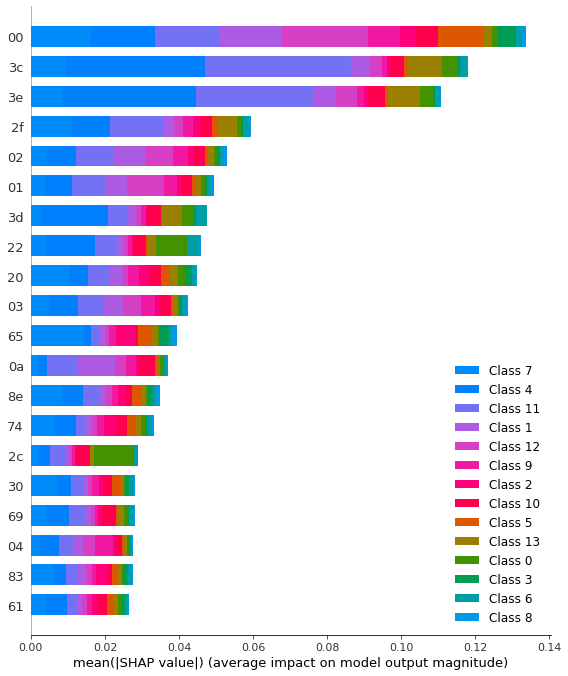

In [31]:
shap.initjs()
shap.summary_plot(shap_values, X_test,show=False)
plt.savefig('rf_summary.png')

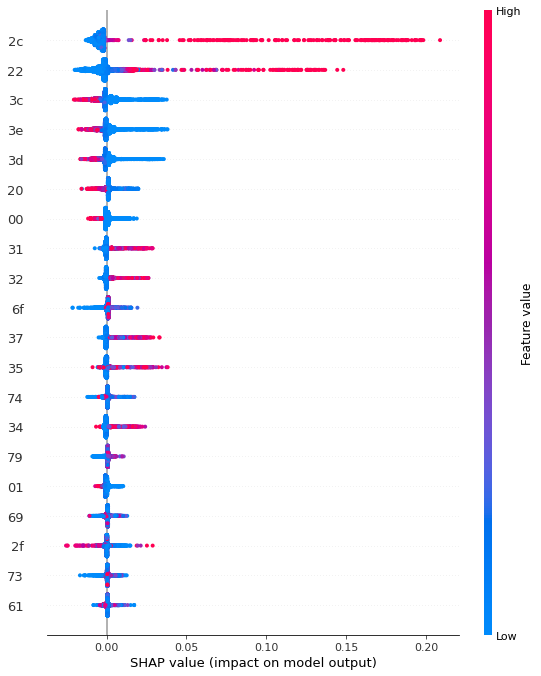

In [32]:
shap.initjs()
shap.summary_plot(shap_values[0], X_test,show=False)
plt.savefig('rf_instance_0.png')

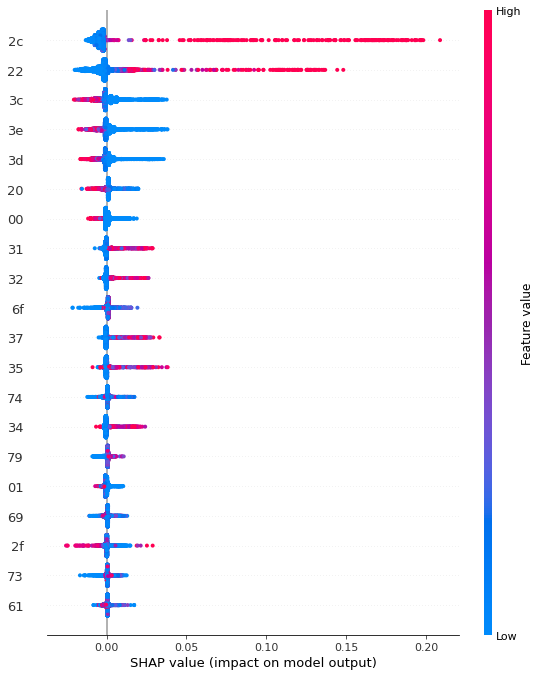

In [33]:
shap.initjs()
shap.summary_plot(shap_values[0], X_test,show=False)
plt.savefig('rf_instance_1.png')

In [34]:
for class_label in range(14):

    shap_values_class = shap_values[class_label]

    explanation = shap.Explanation(values=shap_values_class)

    shap.plots.beeswarm(explanation, max_display=10,show=False)
    
    plt.savefig('rf_' + str(class_label) + '.png', bbox_inches='tight')

    plt.close()

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [59]:
sgd = SGDClassifier(alpha=0.001, max_iter=100)
sgd.fit(X_train, y_train)
print(classification_report(y_test, sgd.predict(X_test)))

              precision    recall  f1-score   support

           1       0.88      0.86      0.87       114
           2       0.56      0.43      0.48       208
           3       0.32      0.77      0.45       219
           4       0.29      0.25      0.27       105
           5       0.68      0.93      0.79       785
           6       0.25      0.37      0.30       197
           7       0.84      0.70      0.76        66
           8       0.79      0.47      0.59       767
           9       0.15      0.36      0.22        55
          10       0.57      0.36      0.44       180
          11       0.57      0.87      0.69       121
          12       0.87      0.50      0.63       602
          13       0.68      0.37      0.48       131
          14       0.65      0.22      0.33        92

    accuracy                           0.59      3642
   macro avg       0.58      0.53      0.52      3642
weighted avg       0.66      0.59      0.59      3642



Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.


In [60]:
explainer = shap.Explainer(sgd, X_train, feature_names=X_train.columns)
shap_values = explainer.shap_values(X_test.values)

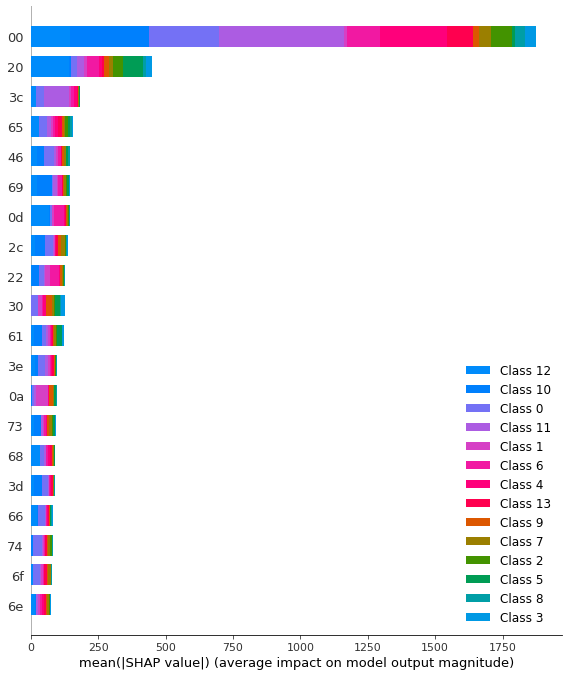

In [61]:
shap.initjs()
shap.summary_plot(shap_values, X_test,show=False)
plt.savefig('sgd_summary.png')

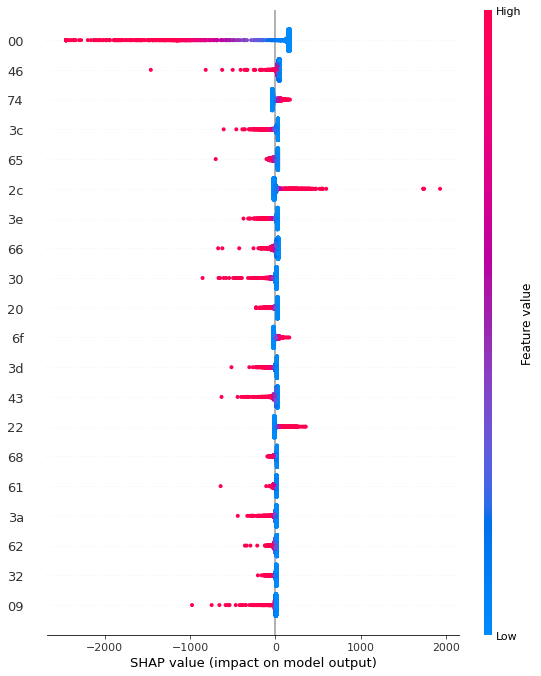

In [62]:
shap.initjs()
shap.summary_plot(shap_values[0], X_test,show=False)
plt.savefig('sgd_instance_0.png')

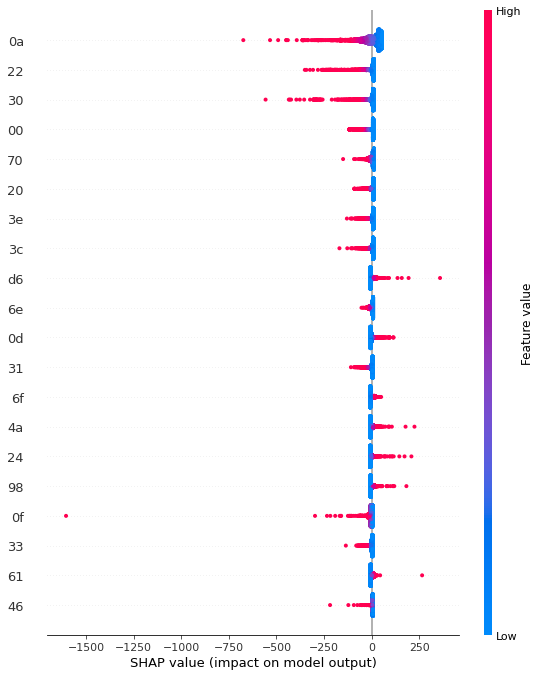

In [63]:
shap.initjs()
shap.summary_plot(shap_values[1], X_test,show=False)
plt.savefig('sgd_instance_1.png')

In [64]:
for class_label in range(14):

    shap_values_class = shap_values[class_label]

    explanation = shap.Explanation(values=shap_values_class)

    shap.plots.beeswarm(explanation, max_display=10,show=False)
    
    plt.savefig('sgd_' + str(class_label) + '.png', bbox_inches='tight')

    plt.close()

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [67]:
nb = GaussianNB()
nb.fit(X_train, y_train)
print(classification_report(y_test, nb.predict(X_test)))

              precision    recall  f1-score   support

           1       0.23      0.96      0.37       114
           2       0.55      0.36      0.44       208
           3       0.60      0.47      0.53       219
           4       0.11      0.90      0.20       105
           5       0.77      0.05      0.09       785
           6       0.24      0.15      0.19       197
           7       0.23      0.85      0.37        66
           8       0.95      0.18      0.31       767
           9       0.56      0.35      0.43        55
          10       0.44      0.12      0.19       180
          11       0.54      0.42      0.47       121
          12       0.44      0.12      0.19       602
          13       0.48      0.73      0.58       131
          14       0.09      0.95      0.17        92

    accuracy                           0.27      3642
   macro avg       0.45      0.47      0.32      3642
weighted avg       0.60      0.27      0.26      3642



In [68]:
explainer = shap.Explainer(nb, X_train, feature_names=X_train.columns)
shap_values = explainer.shap_values(X_test.values)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: GaussianNB()

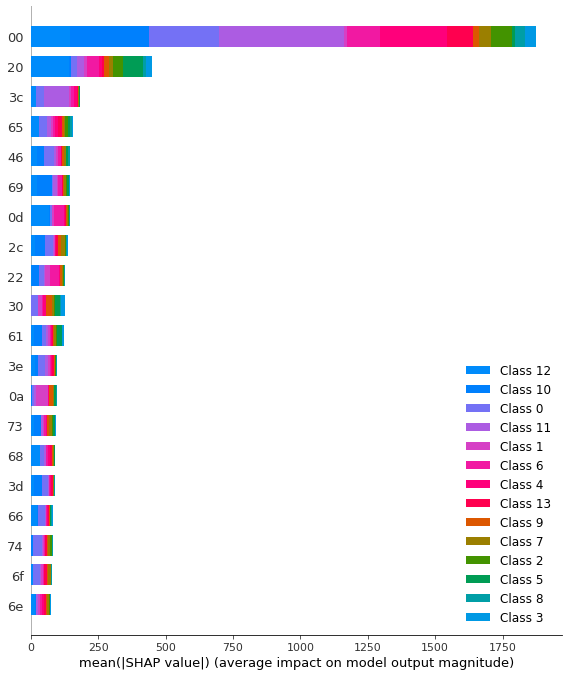

In [69]:
shap.initjs()
shap.summary_plot(shap_values, X_test,show=False)
plt.savefig('nb_summary.png')

In [ ]:
shap.initjs()
shap.summary_plot(shap_values[0], X_test,show=False)
plt.savefig('nb_instance_0.png')

In [ ]:
shap.initjs()
shap.summary_plot(shap_values[0], X_test,show=False)
plt.savefig('nb_instance_1.png')

In [ ]:
for class_label in range(14):

    shap_values_class = shap_values[class_label]

    explanation = shap.Explanation(values=shap_values_class)

    shap.plots.beeswarm(explanation, max_display=10,show=False)
    
    plt.savefig('nb_' + str(class_label) + '.png', bbox_inches='tight')

    plt.close()

In [19]:
feature_scores = np.zeros(X_test.shape[1])

#Iterate through each class and accumulate the absolute SHAP values for each feature
for class_index in range(14):
    shap_values_class = shap_values[class_index].mean(0)  # Aggregate SHAP values across samples
    feature_scores += np.abs(shap_values_class)

# Sort the features by their aggregate scores in descending order
sorted_feature_indices = feature_scores.argsort()[::-1]

top_10_negative_features = sorted_feature_indices[:10]

print("Top 10 features with negative impact across all classes:")
print(top_10_negative_features)

feature_names = df.columns.tolist()

top_10_negative_feature_names = [feature_names[i] for i in top_10_negative_features]

print(top_10_negative_feature_names)

Top 10 features with negative impact across all classes:
[ 0 10 60 34  2  1 44 48 62 47]
['00', '0a', '3c', '22', '02', '01', '2c', '30', '3e', '2f']


In [20]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           1       0.92      0.87      0.89       114
           2       0.77      0.79      0.78       208
           3       0.77      0.39      0.52       219
           4       0.91      0.20      0.33       105
           5       0.87      0.92      0.89       785
           6       0.56      0.29      0.38       197
           7       1.00      0.68      0.81        66
           8       0.60      0.94      0.73       767
           9       1.00      0.07      0.14        55
          10       0.85      0.35      0.50       180
          11       0.90      0.85      0.87       121
          12       0.84      0.90      0.87       602
          13       0.90      0.85      0.88       131
          14       0.98      0.43      0.60        92

    accuracy                           0.76      3642
   macro avg       0.85      0.61      0.66      3642
weighted avg       0.79      0.76      0.74      3642

